### SARIMAX

#### Overview

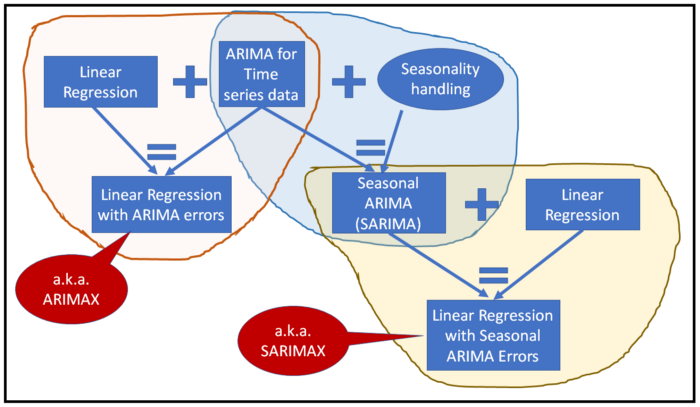

![matrix](https://miro.medium.com/max/700/1*7dR6o-Rk7lMC714KrE_CVg.png)

![regression](https://miro.medium.com/max/675/1*5vybgJ8cBo1FIpNQKY4faw.png)

#### AR

![AR](https://miro.medium.com/max/700/1*07NEweiK6RKABINR4MDp6g.png)

#### MA

![MA](https://miro.medium.com/max/700/1*-Fq1UzuZJDs8uKOng5iaPw.png)

#### ARMA

![ARMA](https://miro.medium.com/max/700/1*Fu__aF9_YS6Y7GyiLtaWQQ.png)

#### I

![diff](https://miro.medium.com/max/700/1*9uXYutuNX4osAyOnLBrXwQ.png)

#### SARIMAX

![sarimax](https://miro.medium.com/max/609/1*VFdkxMszWBzoNI3VYYBokQ.png)

from https://towardsdatascience.com/regression-with-arima-errors-3fc06f383d73

In [30]:
# Import basic modules
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

%matplotlib inline 

def read_owm_data(fn):
    data = pd.read_csv(fn)
    data = data.rename(columns=lambda x: x.strip())  
    
    dates = (data['timestamp']//1000).apply(lambda x: datetime.fromtimestamp(x))
    data.insert(loc=0, column='Dates', value=dates)
    data = data.set_index('Dates')
    data = data.rename(columns={"pwr": "SDGE"})

    time_rs = (data['timestamp'] - data['sunrise']) / (data['sunset'] - data['sunrise'])
    data.insert(loc=len(data.columns)-1, column='time_rs', value=time_rs)

    sdge = data.drop(['timestamp','sunrise','sunset'], axis=1) 
    sdge_lin = pd.get_dummies(sdge)
    
    return sdge_lin, ['temp', 'humidity', 'rain', 'cloud', 'visibility','time_rs']

def train_test(data, test_size = 0.15, test_num = -1, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # get the index after which test set starts
    if test_num == -1:
        test_index = int(len(df)*(1-test_size))
    else:
        test_index = len(df) - test_num
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = df.SDGE.iloc[:test_index]
    X_test = df.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = df.SDGE.iloc[test_index:]    
    
    return X_train, X_test, y_train, y_test

def train_test_rand(data, test_size = 0.15, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    data_X = df.drop('SDGE', axis = 1)
    data_Y = df.SDGE
    X_train0, X_test0, y_train0, y_test0 = train_test_split(data_X, data_Y, test_size=test_size, random_state=7)
    
    X_train = X_train0.copy(deep=True)
    X_test = X_test0.copy(deep=True)
    y_train = y_train0.copy(deep=True)
    y_test = y_test0.copy(deep=True)    
    
    return X_train, X_test, y_train, y_test

def error_metrics(y_pred, y_truth, model_name = None):
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)  

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)
    
    # Explained variance score: 1 is perfect prediction
    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )
    
    name_error = ['model', 'RMSE', 'MAE', 'R2']
    value_error = [model_name, RMSE, MAE, R2]
    list_error = list(zip(name_error, value_error))
    
    # Creating an empty dict to save all the erros from different models
    dict_error = dict()
    
    for error in list_error:
        dict_error[error[0]] = error[1]
        
    return(dict_error)

In [46]:
sdge_lin,cols_to_transform = read_owm_data('all_owm.csv')
print(sdge_lin.head())

X_train, X_test, y_train, y_test = train_test(sdge_lin, test_size = 0.3, scale = False, cols_to_transform=cols_to_transform)

                     temp  humidity  rain  cloud  visibility  time_rs  SDGE
Dates                                                                      
2020-02-18 00:00:00  22.0      56.0   0.0    0.0        90.0    -0.53   0.0
2020-02-18 01:00:00  21.0      56.0   0.0    0.0        90.0    -0.44   0.0
2020-02-18 02:00:00  20.0      60.0   0.0    0.0        80.0    -0.35   0.0
2020-02-18 03:00:00  19.0      63.0   0.0    0.0        80.0    -0.26   0.0
2020-02-18 04:00:00  19.0      63.0   0.0    0.0        80.0    -0.17   0.0


#### Linear regression
Take a look at Durbin-Watson.

In [47]:
from statsmodels.regression import linear_model

In [48]:
olsr_results = linear_model.OLS(y_train, X_train).fit()

y_hat = olsr_results.predict(X_test)

olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   SDGE   R-squared (uncentered):                   0.441
Model:                            OLS   Adj. R-squared (uncentered):              0.440
Method:                 Least Squares   F-statistic:                              566.5
Date:                Thu, 17 Dec 2020   Prob (F-statistic):                        0.00
Time:                        23:10:28   Log-Likelihood:                         -22287.
No. Observations:                4317   AIC:                                  4.459e+04
Df Residuals:                    4311   BIC:                                  4.463e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           1.5683      0.128     12.238      0.000       1.317       1.820
humidity      -0.5454      0.035    -15.561      0.000      -0.614      -0.477
rain         -34.1367      6.988     -4.885      0.000     -47.837     -20.436
cloud          0.0023      0.023      0.099      0.921      -0.043       0.048
visibility     0.3478      0.050      6.945      0.000       0.250       0.446
time_rs      -10.4620      1.196     -8.749      0.000     -12.806      -8.118
==============================================================================
Omnibus:                      581.985   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              496.952
Skew:                           0.747   Prob(JB):                    1.23e-108
Kurtosis:                       2.272   Cond. No.                     1.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Predicted')

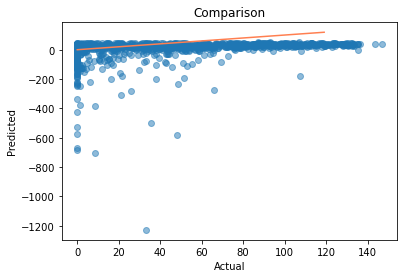

In [49]:
x = np.arange(120)
plt.plot(x,x,color='coral')

plt.scatter(y_test, y_hat, alpha=0.5)
plt.title('Comparison')
plt.xlabel('Actual')
plt.ylabel('Predicted')

#### Auto-correlation

Take a look at LAG-1 and LAG-24.

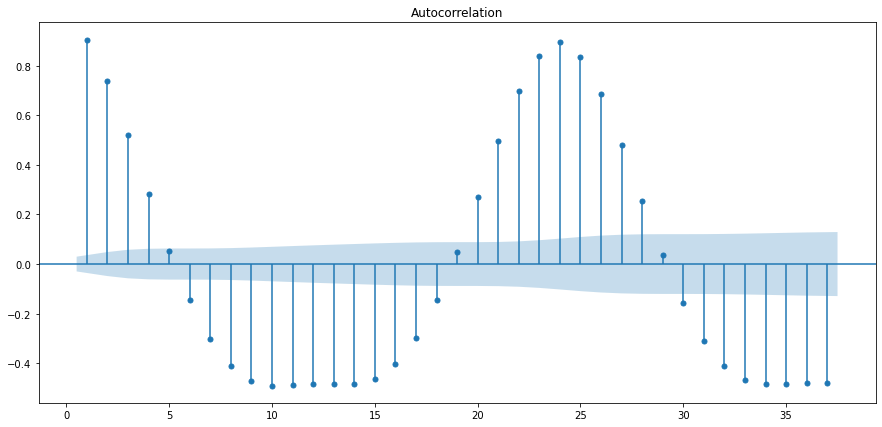

In [50]:
import statsmodels.graphics.tsaplots as tsa

fig, ax = plt.subplots(figsize=(15, 7))
_ = tsa.plot_acf(olsr_results.resid, alpha=0.05, zero=False, ax=ax)

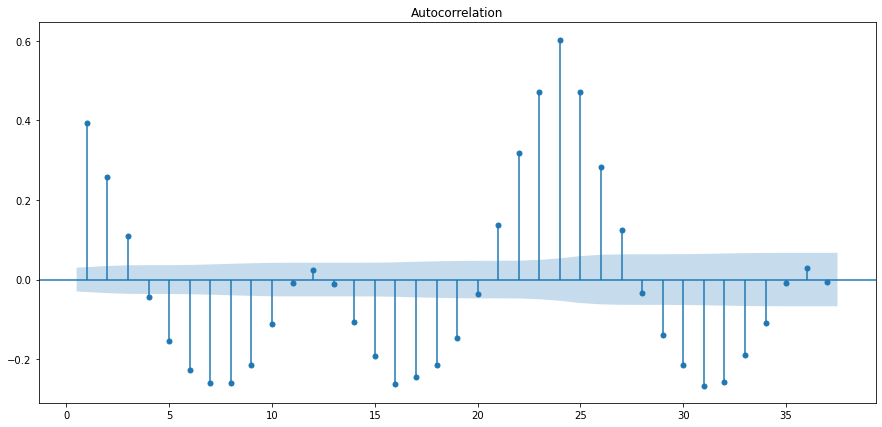

In [51]:
olsr_resid_diff_1 = olsr_results.resid.diff()
olsr_resid_diff_1 = olsr_resid_diff_1.dropna()

fig, ax = plt.subplots(figsize=(15, 7))
_ = tsa.plot_acf(olsr_resid_diff_1, alpha=0.05, zero=False, ax=ax)

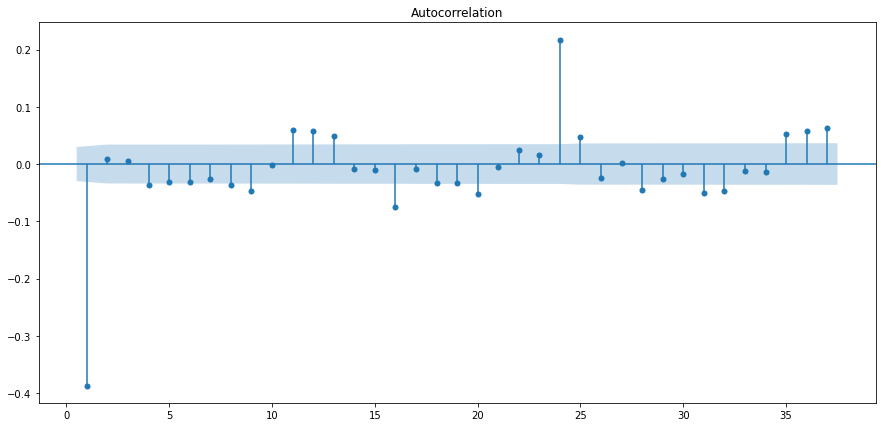

In [52]:
olsr_resid_diff_2 = olsr_resid_diff_1.diff()
olsr_resid_diff_2 = olsr_resid_diff_2.dropna()

fig, ax = plt.subplots(figsize=(15, 7))
_ = tsa.plot_acf(olsr_resid_diff_2, alpha=0.05, zero=False, ax=ax)

##### p=1, d=1, q=0

#### Seasonal decomposition

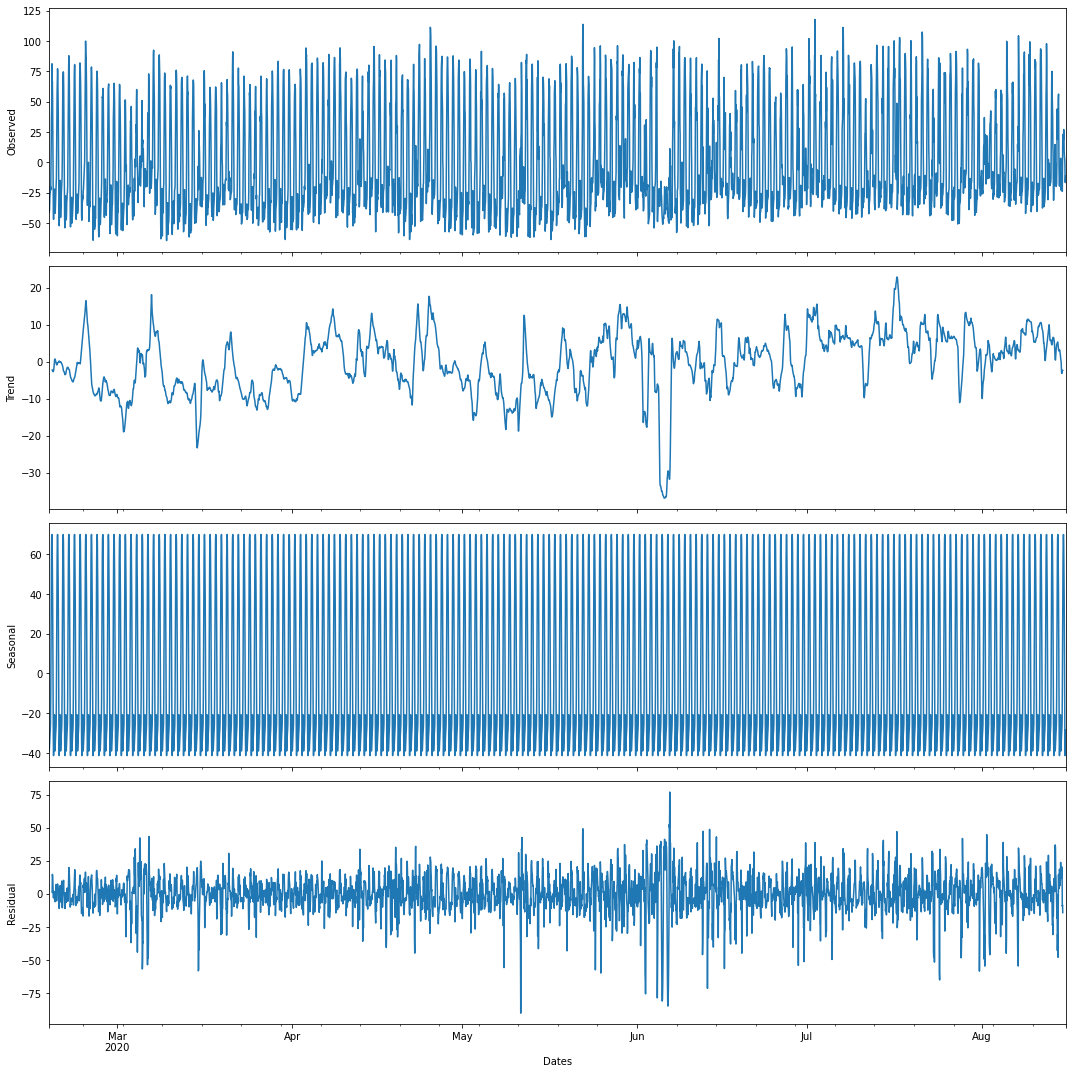

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

components = seasonal_decompose(olsr_results.resid)

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,15))
plotseasonal(components, axes[:])
plt.tight_layout()

##### D=1, m=24

#### Auto-correlation

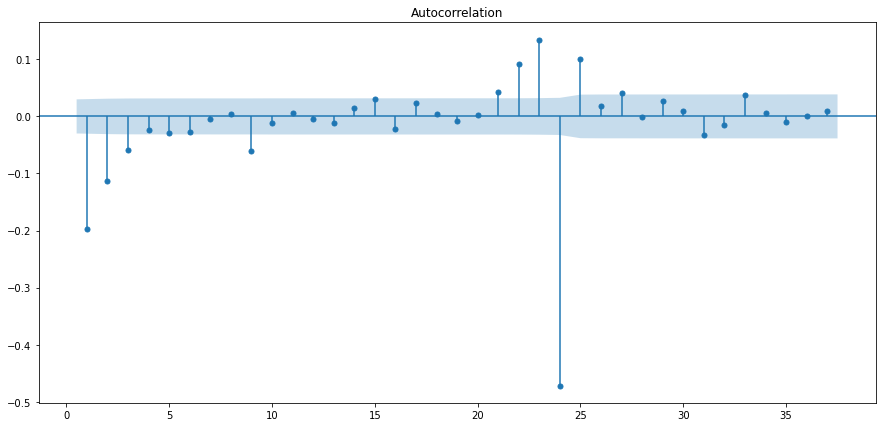

In [65]:
olsr_resid_diff_1_24 = olsr_resid_diff_1.diff(periods=24)
olsr_resid_diff_1_24 = olsr_resid_diff_1_24.dropna()

fig, ax = plt.subplots(figsize=(15, 7))
_ = tsa.plot_acf(olsr_resid_diff_1_24, alpha=0.05, zero=False, ax=ax)

##### Q=1, P=0 (negative LAG-1)

p=1, d=1, q=0, P=0, D=1, Q=1 and m=24 i.e. SARIMAX(1,1,0)(0,1,1)24

#### Build and fit SARIMAX

In [67]:
from statsmodels.tsa.arima.model import ARIMA as ARIMA

In [68]:
X_train = X_train.asfreq('H')
y_train = y_train.asfreq('H')
X_test = X_test.asfreq('H')
y_test = y_test.asfreq('H')

In [69]:
sarimax_model = ARIMA(endog=y_train, exog=X_train, order=(1,1,0), seasonal_order=(0,1,1,24))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               SDGE   No. Observations:                 4317
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 24)   Log Likelihood              -15969.864
Date:                            Thu, 17 Dec 2020   AIC                          31957.727
Time:                                    23:42:59   BIC                          32015.008
Sample:                                02-18-2020   HQIC                         31977.959
                                     - 08-15-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0292      0.189      0.155      0.877      -0.340       0.399
humidity       0.0205      0.034      0.604      0.546      -0.046       0.087
rain           1.0480      3.151      0.333      0.739      -5.129       7.224
cloud         -0.0113      0.007     -1.687      0.092      -0.024       0.002
visibility     0.0227      0.020      1.121      0.262      -0.017       0.062
time_rs       -0.0581     16.157     -0.004      0.997     -31.725      31.609
ar.L1         -0.1069      0.008    -13.437      0.000      -0.123      -0.091
ma.S.L24      -0.9680      0.003   -348.077      0.000      -0.973      -0.963
sigma2        98.3349      0.735    133.849      0.000      96.895      99.775
===================================================================================
Ljung-Box (Q):                      248.16   Jarque-Bera (JB):             45917.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.45   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
lag_hour = 24*3
y_hat = sarimax_results.get_forecast(steps=lag_hour, exog=X_test[:lag_hour])

error_metrics(y_hat.summary_frame()['mean'],y_test[:lag_hour])


Error metrics for model None
RMSE or Root mean squared error: 23.83
Mean Absolute Error: 13.19
Variance score: 0.48


{'model': None,
 'RMSE': 23.828054342445633,
 'MAE': 13.192306677032095,
 'R2': 0.4756552327502175}

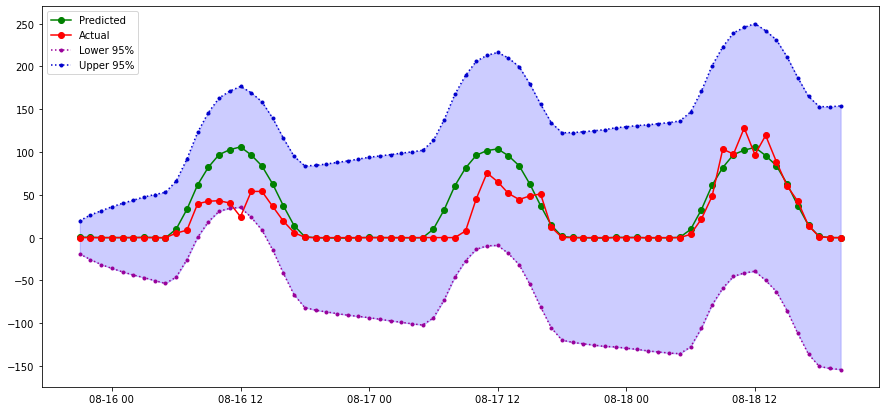

In [77]:
plt.subplots(figsize=(15, 7))
predicted, = plt.plot(X_test[:lag_hour].index, y_hat.summary_frame()['mean'], 'go-', label='Predicted')
actual, = plt.plot(X_test[:lag_hour].index, y_test[:lag_hour], 'ro-', label='Actual')
lower, = plt.plot(X_test[:lag_hour].index, y_hat.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
upper, = plt.plot(X_test[:lag_hour].index, y_hat.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
plt.fill_between(X_test[:lag_hour].index, y_hat.summary_frame()['mean_ci_lower'], y_hat.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
plt.legend(handles=[predicted, actual, lower, upper])

#### Playground


Error metrics for model None
RMSE or Root mean squared error: 21.58
Mean Absolute Error: 13.67
Variance score: 0.57


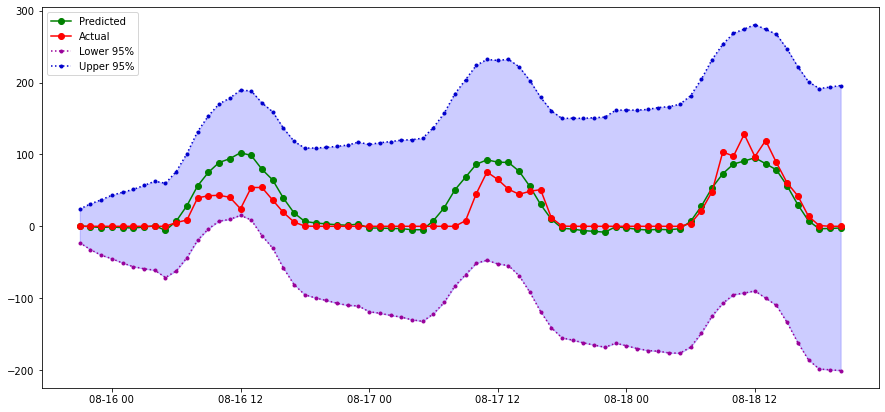

In [88]:
lag_hour_train = 24 * 30
sarimax_model = ARIMA(endog=y_train[-24*30:], exog=X_train[-24*30:], order=(1,1,0), seasonal_order=(0,1,1,24))
sarimax_results = sarimax_model.fit()

y_hat = sarimax_results.get_forecast(steps=lag_hour, exog=X_test[:lag_hour])

error_metrics(y_hat.summary_frame()['mean'],y_test[:lag_hour])

plt.subplots(figsize=(15, 7))
predicted, = plt.plot(X_test[:lag_hour].index, y_hat.summary_frame()['mean'], 'go-', label='Predicted')
actual, = plt.plot(X_test[:lag_hour].index, y_test[:lag_hour], 'ro-', label='Actual')
lower, = plt.plot(X_test[:lag_hour].index, y_hat.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
upper, = plt.plot(X_test[:lag_hour].index, y_hat.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
plt.fill_between(X_test[:lag_hour].index, y_hat.summary_frame()['mean_ci_lower'], y_hat.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
plt.legend(handles=[predicted, actual, lower, upper])